Context : a neo-bank has launched a time-limited promotional offer aiming to attract new clients. For 90d, users can have boosted interest rates on their deposit account, provided that they use their credit card. After 90d, we look how many users churned and left the application, based on the balance they had and the volume of card transactions they made.

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

First we generate the balance and card transactions dataset. We assume that there is a relationship between card transactions and balance. The assumption is that users with more balance will use their card more often.

In [212]:
num_records = 100000
proportion_small = 0.7

# Define an engagement index, skewed toward extreme values
user_engagement_index_low = np.random.triangular(left=0, mode=0.1, right=0.7, size=int(num_records * proportion_small))
user_engagement_index_high = np.random.triangular(left=0.6, mode=0.8, right=1, size=int(num_records * (1 - proportion_small)))
user_engagement_index = np.concatenate([user_engagement_index_low, user_engagement_index_high])

# Add random noise to the engagement index
proportion_noise = 0.5
noise = np.random.normal(loc=0.5, scale=0.3, size=num_records)
user_engagement_index_noisy = noise * (proportion_noise) + user_engagement_index * (1-proportion_noise)

# Derive the balance and the card transactions using the engagement indexes
average_balance_last_90d = (user_engagement_index * 10000).round(2)
nb_card_transactions_last_90d = (user_engagement_index_noisy * 250)

# Create DataFrame
df = pd.DataFrame({
    "average_balance_last_90d": average_balance_last_90d,
    "nb_card_transactions_last_90d": nb_card_transactions_last_90d
})

# Filter out irrelevant records generated by the noise
df = df[(df['nb_card_transactions_last_90d'] >= 0)]
df = df[(df['average_balance_last_90d'] >= 0)]

df.head()

,average_balance_last_90d,nb_card_transactions_last_90d
0,5085.18,132.372375
1,5133.51,189.715217
2,3454.54,50.083104
3,3249.24,110.398433
4,1301.82,30.251680


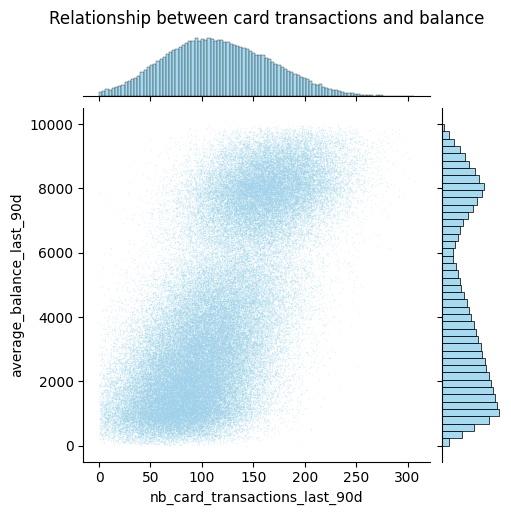

In [213]:
sns.jointplot(x='nb_card_transactions_last_90d', y='average_balance_last_90d', data=df, kind='scatter', color='skyblue', alpha=0.2, marker='o', height=5, s=1)
plt.suptitle('Relationship between card transactions and balance', y=1.02)
plt.show()

More balance is usually related to more churn and more card transactions, but more card transactions has an opposite effect on churn.
Looking at card transactions alone, it seems to have no effect on churn.
Looking at the balance alone, it seems to have a significant impact on churn.

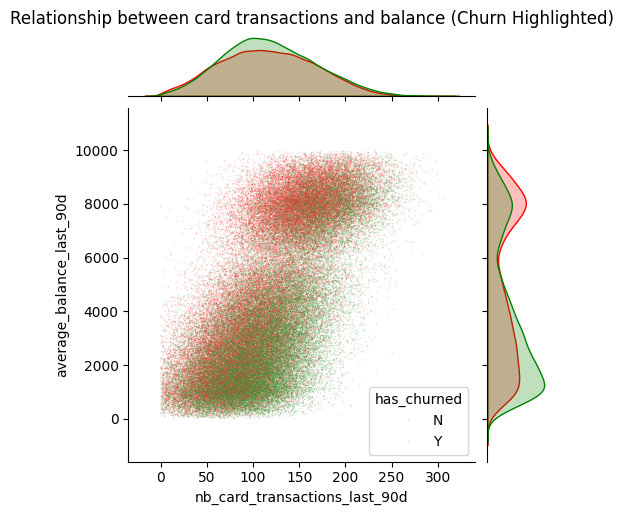

In [214]:
# Define the churn probability
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Calculate churn probability
df['churn_probability'] = sigmoid(
    1 * np.random.normal(loc=0, scale=1, size=len(df))  # Random factor
    + 2 * (df['average_balance_last_90d'] / 10000)      # Balance increases the likelihood to churn
    - 2 * (df['nb_card_transactions_last_90d'] / 250)   # Card usage reduces the likelihood to churn
)

# Assign 'has_churned' based on churn probability
df['has_churned'] = np.where(df['churn_probability'] > 0.5, 'Y', 'N')

# Create scatter plot with hue for churn
sns.jointplot(
    x='nb_card_transactions_last_90d', 
    y='average_balance_last_90d', 
    data=df, 
    kind='scatter', 
    hue='has_churned',
        palette={'Y': 'red', 'N': 'green'},
    alpha=0.2, 
    marker='o', 
    height=5, 
    s=1
)

plt.suptitle('Relationship between card transactions and balance (Churn Highlighted)', y=1.02)
plt.show()

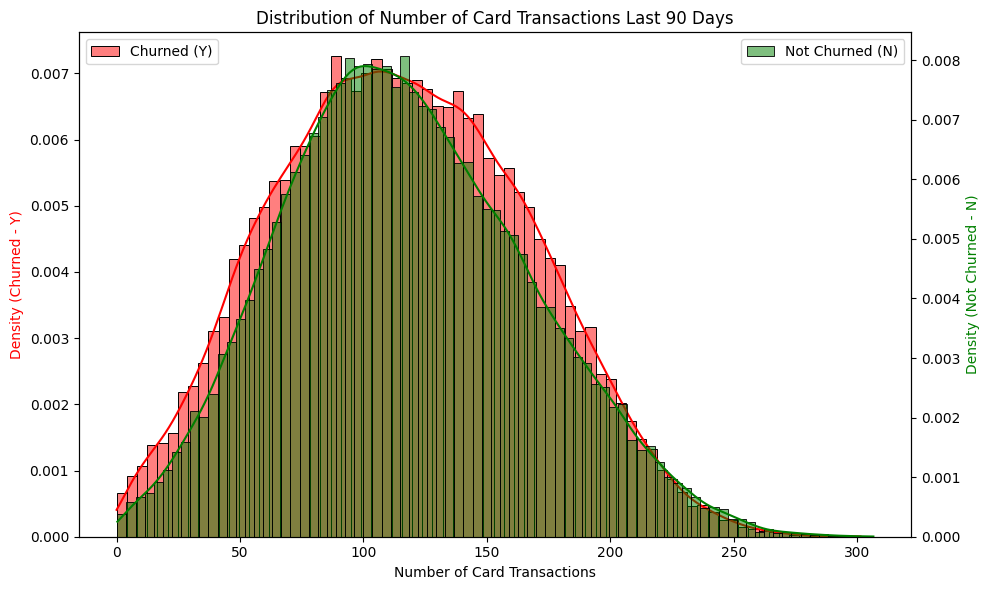

In [215]:
# Define the color palette
palette = {'Y': 'red', 'N': 'green'}

# Plot setup
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for group 'Y' (Churned)
sns.histplot(df[df['has_churned'] == 'Y']['nb_card_transactions_last_90d'], 
             kde=True, color=palette['Y'], ax=ax1, label='Churned (Y)', stat='density')

# Create second y-axis for group 'N' (Not Churned)
ax2 = ax1.twinx()
sns.histplot(df[df['has_churned'] == 'N']['nb_card_transactions_last_90d'], 
             kde=True, color=palette['N'], ax=ax2, label='Not Churned (N)', stat='density')

# Set titles and labels
ax1.set_title('Distribution of Number of Card Transactions Last 90 Days')
ax1.set_xlabel('Number of Card Transactions')
ax1.set_ylabel('Density (Churned - Y)', color=palette['Y'])
ax2.set_ylabel('Density (Not Churned - N)', color=palette['N'])

# Show legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

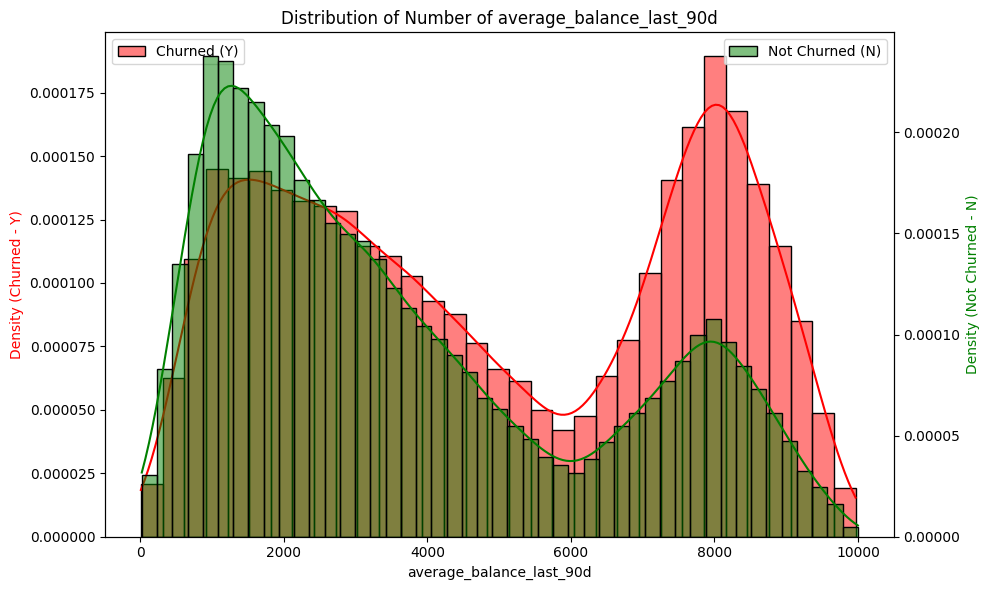

In [216]:
# Define the color palette
palette = {'Y': 'red', 'N': 'green'}

# Plot setup
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for group 'Y' (Churned)
sns.histplot(df[df['has_churned'] == 'Y']['average_balance_last_90d'], 
             kde=True, color=palette['Y'], ax=ax1, label='Churned (Y)', stat='density')

# Create second y-axis for group 'N' (Not Churned)
ax2 = ax1.twinx()
sns.histplot(df[df['has_churned'] == 'N']['average_balance_last_90d'], 
             kde=True, color=palette['N'], ax=ax2, label='Not Churned (N)', stat='density')

# Set titles and labels
ax1.set_title('Distribution of Number of average_balance_last_90d')
ax1.set_xlabel('average_balance_last_90d')
ax1.set_ylabel('Density (Churned - Y)', color=palette['Y'])
ax2.set_ylabel('Density (Not Churned - N)', color=palette['N'])

# Show legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

In [217]:
# Calculate the mean and standard deviation for each feature
mean_transactions = df['nb_card_transactions_last_90d'].mean()
std_transactions = df['nb_card_transactions_last_90d'].std()
mean_balance = df['average_balance_last_90d'].mean()
std_balance = df['average_balance_last_90d'].std()

# Standardize the features to obtain more comparable coefficients
df['nb_card_transactions_last_90d_standardized'] = (df['nb_card_transactions_last_90d'] - mean_transactions) / std_transactions
df['average_balance_last_90d_standardized'] = (df['average_balance_last_90d'] - mean_balance) / std_balance

# Prepare the standardized features for the model
X = df[['nb_card_transactions_last_90d_standardized', 'average_balance_last_90d_standardized']]

# Add constant (intercept) term to the model
X = sm.add_constant(X)

# Define the dependent variable (target)
df['has_churned'] = df['has_churned'].map({'Y': 1, 'N': 0})
y = df['has_churned']

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.643198
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:             has_churned   No. Observations:                99317
Model:                           Logit   Df Residuals:                    99314
Method:                            MLE   Df Model:                            2
Date:              dim., 05 janv. 2025   Pseudo R-squ.:                 0.06973
Time:                         18:44:31   Log-Likelihood:                -63880.
converged:                        True   LL-Null:                       -68669.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                               

In [218]:
# Calculate VIF for each feature
X = X.drop('const', axis=1)  # Exclude constant
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                      Feature       VIF
0  nb_card_transactions_last_90d_standardized  1.871965
1       average_balance_last_90d_standardized  1.871965


Studying the effect of card transaction alone : we see no effect on the churn probability. We must control for the balance and account for the relationship between the two variables for the effect of card transactions to be visible.

In [ ]:
# Prepare the standardized features for the model
X = df['nb_card_transactions_last_90d_standardized']

# Add constant (intercept) term to the model
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the model
print(result.summary()) 

Optimization terminated successfully.
         Current function value: 0.691275
         Iterations 3
                            Logit Regression Results                           
Dep. Variable:             has_churned   No. Observations:                99317
Model:                           Logit   Df Residuals:                    99315
Method:                            MLE   Df Model:                            1
Date:              dim., 05 janv. 2025   Pseudo R-squ.:               0.0001923
Time:                         18:44:31   Log-Likelihood:                -68655.
converged:                        True   LL-Null:                       -68669.
Covariance Type:             nonrobust   LLR p-value:                 2.758e-07
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                               